In [1]:
import cv2
import numpy as np
import os
import scipy.io as io
import matplotlib.pyplot as plt
import pickle

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import layers

import random
from tqdm import tqdm
from scipy.spatial.transform import Rotation

In [2]:
# %load_ext autoreload
# %autoreload 2
# %reload_ext autoreload

In [3]:
IMG_SIZE=96

In [867]:
def channel_shift(img):
    value1 = random.random()*1.+0.6
    value2 = random.random()*0.5-0.25
    img = img*value1 + value2
    #img[:,:,:][img[:,:,:]>1]  = 1
    #img[:,:,:][img[:,:,:]<0]  = 0
    if random.random() < 0.3:
        img = np.flip(img,2)
    return img

def rotation(img, mask, angle):
    angle = int(random.uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    mask = cv2.warpAffine(mask, M, (w, h))
    return img, mask

def flip(img,mask):
    if random.random() < 0.5:
        img = np.flip(img,1)
        mask = np.flip(mask,1)
    return img, mask

def random_rectangles(img, number, size_perc, whole = True):
    size = img.shape[0]
    for i in range(number):
        x1 = int(random.random()*(size-5))
        x2 = int(random.random()*(size*size_perc))
        y1 = int(random.random()*(size-5))
        y2 = int(random.random()*(size*size_perc))

        if whole and random.random() < 0.5:
            r = random.random()
            g = random.random()
            b = random.random()
            if random.random() < 0.7:
                img[y1:y2+y1,x1:x2+x1] = [r,g,b]
            else:
                fill = int(random.random()*3)*1-1
                img = cv2.circle(img,(x1,y1),int(size_perc * size/2),(r,g,b), fill)
        if not whole and random.random() < 0.5:
            img[y1:y2+y1,x1:x2+x1] *= random.random()+0.5 + random.random()-0.3
    return img

In [5]:
K1 = np.array([[1.066778e+03, 0.000000e+00, 3.129869e+02],
               [0.000000e+00, 1.067487e+03, 2.413109e+02],
               [0.000000e+00, 0.000000e+00, 1.000000e+00]])

K2 = np.array([[1077.836, 0, 323.7872],
               [0, 1078.189, 279.6921],
               [0,        0,        1]])

verts = [
        [-0.01,0,0],
        [0.08,0.05,0.0],
        [-0.1,0.045,0.0],
        [-0.03,-0.11,0.023],
        [-0.03,-0.11,-0.023],
        [0.055,-0.11,0.023],
        [0.055,-0.11,-0.023]
        ]
verts  = np.array(verts)
color = (0,255,255)

def get_x_y(verts, idx):
    t = poses[idx][4:,None]
    quat = -np.array([*poses[idx][1:4], poses[idx][0]])
    R = np.array(Rotation.from_quat(quat).as_matrix())

    K_ = K1 if idx <= 23820 else K2

    verts_2d = np.matmul(K_, np.matmul(R, verts.T) + t).T
    verts_2d = verts_2d[:,:2] / verts_2d[:,2,None]
    return verts_2d

In [8]:
ycb_path = "C:\\Users\\mati\\Desktop\\Moje\\dyplomowa\\datasets\\ycb_video_sicrod"
power_screwdriver_name = "power_screwdriver"
poses_file_name = "035_power_drill.txt"
poses_file_path = os.path.join(ycb_path,poses_file_name)
frames_path = os.path.join(ycb_path,power_screwdriver_name)

poses = np.loadtxt(poses_file_path)

In [9]:
os.listdir(frames_path)

['0006',
 '0009',
 '0010',
 '0011',
 '0012',
 '0018',
 '0024',
 '0030',
 '0037',
 '0038',
 '0050',
 '0054',
 '0056',
 '0059',
 '0077',
 '0081',
 '0083',
 '0086',
 '0088']

In [472]:
train_types = ['0006', '0009', '0010', '0012', '0018', '0024', '0030', '0038',
                '0050','0056','0059','0077','0081','0083','0086','0088']
val_types = ['0011', '0037', '0054']

dir_types = os.listdir(frames_path)
train_color_frame_paths = []
train_depth_frame_paths = []
val_color_frame_paths = []
val_depth_frame_paths = []
train_idx_pose = {}
val_idx_pose = {}
idx = 0
train_idx = 0
val_idx = 0
for dir_type in dir_types:
    dir_1 = os.path.join(frames_path,dir_type)
    for file_name in os.listdir(dir_1):
        if "color" in file_name and dir_type in train_types:
            train_color_frame_paths.append(os.path.join(dir_1,file_name))
            train_idx_pose[train_idx] = idx
            train_idx += 1
            idx += 1
        if "color" in file_name and dir_type in val_types:
            val_color_frame_paths.append(os.path.join(dir_1,file_name))
            val_idx_pose[val_idx] = idx
            val_idx += 1
            idx += 1
        if "depth" in file_name and dir_type in train_types:
            train_depth_frame_paths.append(os.path.join(dir_1,file_name))
        if "depth" in file_name and dir_type in val_types:
            val_depth_frame_paths.append(os.path.join(dir_1,file_name))

In [473]:
print(len(train_color_frame_paths ))
print(len(val_depth_frame_paths))

22693
5190


In [474]:
train_color_frames = []
train_depth_frames = []
for color_path, depth_path in tqdm(zip(train_color_frame_paths, train_depth_frame_paths)):
        color_frame = cv2.imread(color_path)
        #depth_frame = cv2.imread(depth_path)
        
        color_frame = cv2.resize(color_frame,(IMG_SIZE,IMG_SIZE))/255.
        #depth_frame = cv2.resize(depth_frame,(IMG_SIZE,IMG_SIZE))/255.
        
        train_color_frames.append(color_frame)
        #train_depth_frames.append(depth_frame)

22693it [03:07, 120.96it/s]


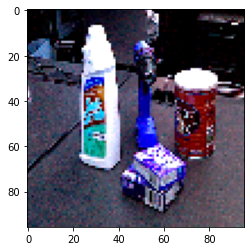

In [475]:
plt.imshow(train_color_frames[100])

In [476]:
val_color_frames = []
val_depth_frames = []
for color_path, depth_path in tqdm(zip(val_color_frame_paths, val_depth_frame_paths)):
        color_frame = cv2.imread(color_path)
        #depth_frame = cv2.imread(depth_path)
        
        color_frame = cv2.resize(color_frame,(IMG_SIZE,IMG_SIZE))/255.
        #depth_frame = cv2.resize(depth_frame,(IMG_SIZE,IMG_SIZE))/255.
        
        val_color_frames.append(color_frame)
        #val_depth_frames.append(depth_frame)

5190it [00:51, 100.10it/s]


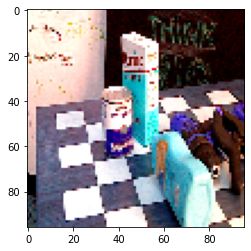

In [477]:
plt.imshow(val_color_frames[3000])

In [478]:
def get_mask(points, original_frame_shape):
    
    SIZE_X = original_frame_shape[1]
    SIZE_Y = original_frame_shape[0]
    joint_masks = []
    joint_idx = 0
    joints_number = len(points)
    mask = np.zeros((7,IMG_SIZE,IMG_SIZE))
    for i, point in enumerate(points):
        
        
        x = point[0]
        y = point[1]

        x = int(x/(SIZE_X/IMG_SIZE))
        y = int(y/(SIZE_Y/IMG_SIZE))
        color = (255,255,255)
        mask[i] = cv2.circle(mask[i],(x,y),7,color, -1)
        joint_masks.append(mask[i])
        
    #joint_masks = np.array(joint_masks)
    joint_masks = np.swapaxes(joint_masks, 0,-1)
    joint_masks = np.swapaxes(joint_masks, 0,1)
            
    return joint_masks/255.

In [881]:
def power_driver_generator(color_frames,depth_frames,idx_pose,augmentation = False):
    while True:
        idx = int(random.random()*len(color_frames))

        points = get_x_y(verts, idx_pose[idx])
        
        mask = get_mask(points, original_frame_shape = [480,640])
        color_frame = color_frames[idx].copy()
        #depth_frame = depth_frames[idx].copy()
        
        if augmentation:
            color_frame = random_rectangles(color_frame, 100, 0.05, True)
            color_frame = random_rectangles(color_frame, 10, 0.2, True)
            color_frame = random_rectangles(color_frame, 2, 0.4, True)
            color_frame = random_rectangles(color_frame, 20, 0.1, False)
            color_frame = random_rectangles(color_frame, 20, 0.4, False)
            color_frame = random_rectangles(color_frame, 4, 1, False)
            if (random.random() < 0.5):
                color_frame, mask = rotation(color_frame, mask, 60)
            color_frame = random_rectangles(color_frame, 100, 0.05, True)
            color_frame = random_rectangles(color_frame, 10, 0.2, True)
            color_frame = random_rectangles(color_frame, 2, 0.4, True)
            color_frame = random_rectangles(color_frame, 25, 0.1, False)
            color_frame = random_rectangles(color_frame, 10, 0.4, False)
            color_frame = random_rectangles(color_frame, 10, 1, False)
            if (random.random() < 0.5):
                color_frame, mask = rotation(color_frame, mask, 60)
            color_frame = random_rectangles(color_frame, 100, 0.05, True)
            color_frame = random_rectangles(color_frame, 10, 0.2, True)
            color_frame = random_rectangles(color_frame, 2, 0.4, True)
            color_frame = random_rectangles(color_frame, 25, 0.1, False)
            color_frame = random_rectangles(color_frame, 15, 0.4, False)
            color_frame = random_rectangles(color_frame, 10, 1, False)
            color_frame, mask = flip(color_frame, mask)
            color_frame = channel_shift(color_frame)
        yield color_frame, mask

In [882]:
train_generator = power_driver_generator(train_color_frames, train_depth_frames, train_idx_pose,augmentation=True)
val_generator = power_driver_generator(val_color_frames, val_depth_frames, val_idx_pose)

In [883]:
for i in range(100):
    x,y = next(val_generator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


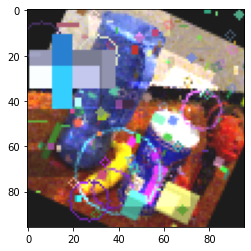

In [890]:
x,y = next(train_generator)
plt.imshow(x)

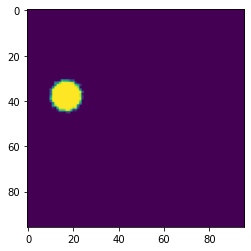

In [659]:
plt.imshow(y[:,:,2])

## Utils

In [439]:
def get_blob_center(heatmap):
    
    heatmap_size = heatmap.shape[0]
    heatmap = np.abs(heatmap)
    heatmap = heatmap*heatmap*heatmap
    
    dx = np.array(np.arange(0,heatmap_size))
    dx = np.expand_dims(dx,0)
    dx = np.repeat(dx,heatmap_size, axis=0)
    dy = np.rot90(dx, k=3)

    heatmap_dx = dx*heatmap
    heatmap_dy = dy*heatmap
    
    sumed_heatmap = np.sum(heatmap)
    x = np.sum(heatmap_dx)/sumed_heatmap
    y = np.sum(heatmap_dy)/sumed_heatmap
    return np.array([x, y])

def isNaN(num):
    return num != num

def calc_blob_distances(mask_gt, mask_pred):
    distances = []
    for i in range(mask_gt.shape[-1]):
        heatmap_gt, heatmap_pred = mask_gt[:,:,i],mask_pred[:,:,i]
        p_gt = get_blob_center(heatmap_gt)
        p_pred = get_blob_center(heatmap_pred)
        distance = np.linalg.norm(p_gt-p_pred)
        if isNaN(distance):
            distance = None
        distances.append(distance)
    cleaned_distances = [x for x in distances if x != None]
    return cleaned_distances
        
def calc_oks_metric(model_to_eval, val_generator, probes):
    
    x = []
    y_gt = []
    for probe in range(probes):
        x1, y_gt1 = next(val_generator)
        x.append(x1)
        y_gt.append(y_gt1)
    all_frames_distances = []
    y_pred = model_to_eval.predict(np.array(x),verbose = 0)
    for probe in range(probes):
        per_frame_distances = calc_blob_distances(y_gt[probe],y_pred[probe])
        per_frame_distances_avg = np.average(per_frame_distances)
        #print(per_frame_distances_avg)
        all_frames_distances.append(per_frame_distances_avg)
    average_dist = np.average(all_frames_distances)
    return average_dist

In [440]:
history_oks = []

In [441]:
class my_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, batch, logs=None):
        train_oks = calc_oks_metric(model_2, train_generator, 500)
        val_oks = calc_oks_metric(model_2, val_generator, 500)
        history_oks.append((train_oks,val_oks))
        print()
        print("train_oks:", train_oks, "val_oks:",val_oks)
        return None

## Model

In [662]:
w_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

In [663]:
def unet_conv(inputs, filters, dropout=0.4,kernel_size=3, padding="same", strides=2, activation=True):
    x = Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        kernel_initializer=w_init,
        padding=padding,
        strides=strides,
    )(inputs)
    if activation:
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Dropout(dropout)(x)
    return x

In [664]:
def unet_up_conv(inputs, filters, dropout=0.4,kernel_size=3, padding="same", strides=2, activation=True):
    x = Conv2DTranspose(
        filters=filters,
        kernel_size=kernel_size,
        kernel_initializer=w_init,
        padding=padding,
        strides=strides,
        use_bias=True
    )(inputs)
    if activation:
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Dropout(dropout)(x)
    return x

In [665]:
def build_generator(img_size=32, num_channels=3):
    
    ch_r = 4
    inputs = keras.Input(shape=(img_size,img_size,num_channels,))
    x1 = unet_conv(inputs, filters = 16, strides = 1)
    
    x2 = unet_conv(x1, filters = 4*ch_r, strides = 2)
    x3 = unet_conv(x2, filters = 8*ch_r, strides = 1)
    
    x4 = unet_conv(x3, filters = 8*ch_r, strides = 2)
    x5 = unet_conv(x4, filters = 16*ch_r, strides = 1)
    
    x6 = unet_conv(x5, filters = 16*ch_r, strides = 2)
    x7 = unet_conv(x6, filters = 32*ch_r, strides = 1)
    
    
    x8 = unet_conv(x7, filters = 32*ch_r, strides = 2)
    x9 = unet_conv(x8, filters = 64*ch_r, strides = 1)
    
    x10 = unet_up_conv(x9, filters = 64*ch_r, strides = 2)
    
    
    x = layers.concatenate([x7, x10])
    x11 = unet_conv(x, filters = 32*ch_r, strides = 1)
    x12 = unet_up_conv(x11, filters = 16*ch_r, strides = 2)
    
    x = layers.concatenate([x5, x12])
    x13 = unet_conv(x, filters = 16*ch_r, strides = 1)
    x14 = unet_up_conv(x13, filters = 8*ch_r, strides = 2)
    
    x = layers.concatenate([x3, x14])
    x15 = unet_conv(x, filters = 8*ch_r, strides = 1)
    x16 = unet_up_conv(x15, filters = 4*ch_r, strides = 2)
    
    x = layers.concatenate([x1, x16, inputs])
    x17 = unet_conv(x, filters = 16, strides = 1)
    
    x = layers.Conv2D(7, kernel_size = 3, padding="same")(x17)
    output = Activation("sigmoid", name="head1")(x)

    # Define the model
    model = keras.Model(inputs, outputs = [output])
    
    return model
    
    

In [666]:
model_2 = build_generator(IMG_SIZE)

In [667]:
model_2.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_196 (Conv2D)            (None, 96, 96, 16)   448         ['input_15[0][0]']               
                                                                                                  
 batch_normalization_238 (Batch  (None, 96, 96, 16)  64          ['conv2d_196[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 re_lu_238 (ReLU)               (None, 96, 96, 16)   0           ['batch_normalization_238[

                                                                                                  
 dropout_246 (Dropout)          (None, 6, 6, 256)    0           ['re_lu_246[0][0]']              
                                                                                                  
 conv2d_transpose_56 (Conv2DTra  (None, 12, 12, 256)  590080     ['dropout_246[0][0]']            
 nspose)                                                                                          
                                                                                                  
 batch_normalization_247 (Batch  (None, 12, 12, 256)  1024       ['conv2d_transpose_56[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 re_lu_247 (ReLU)               (None, 12, 12, 256)  0           ['batch_normalization_247[0][0]']
          

 conv2d_208 (Conv2D)            (None, 96, 96, 16)   5056        ['concatenate_59[0][0]']         
                                                                                                  
 batch_normalization_254 (Batch  (None, 96, 96, 16)  64          ['conv2d_208[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 re_lu_254 (ReLU)               (None, 96, 96, 16)   0           ['batch_normalization_254[0][0]']
                                                                                                  
 dropout_254 (Dropout)          (None, 96, 96, 16)   0           ['re_lu_254[0][0]']              
                                                                                                  
 conv2d_209 (Conv2D)            (None, 96, 96, 7)    1015        ['dropout_254[0][0]']            
          

In [891]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, batch_size, gen, size):
        self.batch_size = batch_size
        self.on_epoch_end()
        self.gen = gen
        self.size = size
    def __len__(self):
        return int(self.size/self.batch_size)

    def __getitem__(self, index):
        #index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        #batch = [self.indices[k] for k in index]
        
        x_train = []
        y_train = []
        for i in range(self.batch_size):
            x, y = next(self.gen)
            x_train.append(x)
            y_train.append(y)
            
        x_train = np.array(x_train)
        y_train = np.array(y_train)
        
        return x_train, y_train

    def on_epoch_end(self):
        pass


In [892]:
tf_train_generator = DataGenerator(batch_size=16, gen=train_generator, size = 22000/5)
tf_val_generator = DataGenerator(batch_size=16, gen=val_generator, size = 22000/5)

## Training

In [918]:
opt = tf.keras.optimizers.Adam(learning_rate=0.003)
model_2.compile(optimizer=opt, loss = "mse")

In [38]:
model_2.fit(tf_train_generator, 
            validation_data = tf_val_generator,  
            epochs = 100, batch_size = 16,
           #callbacks=[my_callback()]
           )

Epoch 1/100
240/240 [==============================] - 29s 59ms/step - loss: 0.0379 - val_loss: 0.0155
Epoch 2/100
240/240 [==============================] - 14s 58ms/step - loss: 0.0148 - val_loss: 0.0136
Epoch 3/100
240/240 [==============================] - 14s 58ms/step - loss: 0.0135 - val_loss: 0.0132
Epoch 4/100
240/240 [==============================] - 14s 57ms/step - loss: 0.0101 - val_loss: 0.0139
Epoch 5/100
240/240 [==============================] - 14s 57ms/step - loss: 0.0069 - val_loss: 0.0133
Epoch 6/100
240/240 [==============================] - 14s 57ms/step - loss: 0.0046 - val_loss: 0.0132
Epoch 7/100
240/240 [==============================] - 14s 57ms/step - loss: 0.0037 - val_loss: 0.0132
Epoch 8/100
240/240 [==============================] - 14s 57ms/step - loss: 0.0033 - val_loss: 0.0135
Epoch 9/100
240/240 [==============================] - 14s 58ms/step - loss: 0.0030 - val_loss: 0.0130
Epoch 10/100
240/240 [==============================] - 14s 58ms/step - l

KeyboardInterrupt: 

In [927]:
model_2.fit(tf_train_generator, 
            validation_data = tf_val_generator,  
            epochs = 100, batch_size = 16,
           #callbacks=[my_callback()]
           )

Epoch 1/100
275/275 [==============================] - 37s 135ms/step - loss: 0.0093 - val_loss: 0.0113
Epoch 2/100
275/275 [==============================] - 37s 134ms/step - loss: 0.0093 - val_loss: 0.0113
Epoch 3/100
275/275 [==============================] - 37s 133ms/step - loss: 0.0093 - val_loss: 0.0117
Epoch 4/100
275/275 [==============================] - 36s 131ms/step - loss: 0.0092 - val_loss: 0.0117
Epoch 5/100
275/275 [==============================] - 37s 134ms/step - loss: 0.0093 - val_loss: 0.0114
Epoch 6/100
275/275 [==============================] - 37s 134ms/step - loss: 0.0092 - val_loss: 0.0115
Epoch 7/100
275/275 [==============================] - 37s 133ms/step - loss: 0.0093 - val_loss: 0.0115
Epoch 8/100
275/275 [==============================] - 37s 136ms/step - loss: 0.0092 - val_loss: 0.0114
Epoch 9/100
275/275 [==============================] - 36s 132ms/step - loss: 0.0091 - val_loss: 0.0114
Epoch 10/100
275/275 [==============================] - 36s 129m

275/275 [==============================] - 36s 131ms/step - loss: 0.0090 - val_loss: 0.0112
Epoch 80/100
275/275 [==============================] - 36s 131ms/step - loss: 0.0088 - val_loss: 0.0113
Epoch 81/100
275/275 [==============================] - 36s 133ms/step - loss: 0.0089 - val_loss: 0.0113
Epoch 82/100
275/275 [==============================] - 37s 133ms/step - loss: 0.0089 - val_loss: 0.0118
Epoch 83/100
275/275 [==============================] - 37s 136ms/step - loss: 0.0091 - val_loss: 0.0116
Epoch 84/100
275/275 [==============================] - 37s 135ms/step - loss: 0.0089 - val_loss: 0.0117
Epoch 85/100
275/275 [==============================] - 37s 134ms/step - loss: 0.0090 - val_loss: 0.0115
Epoch 86/100
275/275 [==============================] - 37s 133ms/step - loss: 0.0089 - val_loss: 0.0119
Epoch 87/100
275/275 [==============================] - 37s 134ms/step - loss: 0.0089 - val_loss: 0.0117
Epoch 88/100
275/275 [==============================] - 37s 133ms/st

## Evaluating

In [906]:
model_2.evaluate(tf_val_generator)

275/275 [==============================] - 9s 32ms/step - loss: 0.0112


0.011157886125147343

In [923]:
import pnp_manager
from pnp_manager import FramesGeneratorManager 

In [924]:
frames_gen = FramesGeneratorManager(dir_path = frames_path,
                                   video_number = "0037",
                                   target_resolution = [96,96],
                                   skip_frames = 6)

In [925]:
def put_keypoints_on_frame(frame,scale):
    mask = model_2.predict(np.array([frame/255.]),verbose=0)[0]
    blobs_centers = pnp_manager.get_all_blobs_centers(mask)
    frame = cv2.resize(frame,(frame.shape[0]*scale, frame.shape[1]*scale))
    for center in blobs_centers:
        x = int(center[0])*scale
        y = int(center[1])*scale
        color = (0,255,0)
        frame = cv2.circle(frame,(x,y),2*scale,color, -1)
    return frame

In [926]:
for i in range(250):
    frame = frames_gen.get_next_frame()
    frame = put_keypoints_on_frame(frame,4)
    
    cv2.imshow("window1", frame)
    cv2.waitKey(1)
cv2.destroyAllWindows()

In [852]:
cv2.destroyAllWindows()

In [ ]:
######### PNP ######### PNP ######### PNP ######### PNP ######### PNP ######### PNP
######### PNP ######### PNP ######### PNP ######### PNP ######### PNP ######### PNP
######### PNP ######### PNP ######### PNP ######### PNP ######### PNP ######### PNP

In [374]:
points_3d = [
             (0.0, 0.0,0.0),
             (0.0, 0.0,0.1),
             (0.0, 0.1,0.0),
             (0.1, 0.0,0.0),
            ]

In [376]:
solverPNP = pnp_manager.SolverPNP((96,96))

for i in range (50):
    frame = frames_gen.get_next_frame()
    mask = model_2.predict(np.array([frame/255.]),verbose=0)[0]
    blobs_centers = pnp_manager.get_all_blobs_centers(mask)
    points_2d = solverPNP.projectPoints(blobs_centers, points_3d)
    scale = 4
    frame = cv2.resize(frame,(96*scale,96*scale))
    color = (255,0,0)
    
    for point in points_2d:
        x = int(point[0][0])
        y = int(point[0][1])
        frame = cv2.circle(frame,(x*scale,y*scale),2*scale,color, -1)

    cv2.imshow("window1", frame)
    cv2.waitKey(1)
cv2.destroyAllWindows()